In [1]:
import pandas as pd
import glob
import os
import datetime as dt
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns

In [2]:
# Specify the date
day = 20200216
date = dt.datetime(2020, 2, 16)

In [3]:
# Define paths for loading data
directory = '/home/jari/Documents/IPSP/Bachelorarbeit/'    
seapath = sorted(glob.glob(os.path.join(directory + 'DSHIP/RV*.dat')))
arduino_pitch = sorted(glob.glob(os.path.join(directory + 'arduino_clean_data/2*_pitch_cleanest.csv')))
arduino_roll = sorted(glob.glob(os.path.join(directory + 'arduino_clean_data/2*_roll_cleanest.csv')))
limrad94 = sorted(glob.glob(os.path.join(directory + 'angles/*.csv')))

In [4]:
# Create functions for reading data
def read_seapath(day):
    df_seapath = pd.read_csv(f'/home/jari/Documents/IPSP/Bachelorarbeit/DSHIP/RV-Meteor_DSHIP_all_1Hz_{day}.dat',
        encoding='windows-1252', sep='\t', na_values='-999.0').loc[:,['date time','FOG.PPPRP.pitch','FOG.PPPRP.roll']]
    df_seapath.set_index('date time', inplace=True)
    df_seapath.index = pd.to_datetime(df_seapath.index, format="%Y-%m-%d %H:%M:%S")
    return df_seapath

def read_arduino_pitch(day):
    df_arduino_pitch = pd.read_csv(f'/home/jari/Documents/IPSP/Bachelorarbeit/arduino_clean_data/{day}_attitude_arduino_pitch_cleanest.csv',
        na_values='-999.0')
    df_arduino_pitch.set_index('datetime', inplace=True)
    df_arduino_pitch.index = pd.to_datetime(df_arduino_pitch.index, format="%Y-%m-%d %H:%M:%S")
    return df_arduino_pitch

def read_arduino_roll(day):
    df_arduino_roll = pd.read_csv(f'/home/jari/Documents/IPSP/Bachelorarbeit/arduino_clean_data/{day}_attitude_arduino_roll_cleanest.csv',
        na_values='-999.0')
    df_arduino_roll.set_index('datetime', inplace=True)
    df_arduino_roll.index = pd.to_datetime(df_arduino_roll.index, format="%Y-%m-%d %H:%M:%S")
    return df_arduino_roll
    
def read_limrad94(day):
    df_limrad94 = (pd.read_csv(f'/home/jari/Documents/IPSP/Bachelorarbeit/angles/RV-Meteor_cloudradar_attitude-angles_{day}.csv',
        na_values='-999.0').loc[:,['datetime', 'roll', 'pitch']])
    df_limrad94.set_index('datetime', inplace=True)
    df_limrad94.index = pd.to_datetime(df_limrad94.index, format="%Y-%m-%d")
    return df_limrad94

In [5]:
# Create a list with the days
days = []
for file in arduino_pitch:
    days.append(file[-44:-36])
days1 = days[0:9]
days2 = days[9:20]
days3 = days[20:30]
days4 = days[30:40]

# Create a list with the days in datetime format
dates1 = []
dates2 = []
dates3 = []
dates4 = []
for day in days1:
    dates1.append(dt.datetime.strptime(day, '%Y%m%d'))
for day in days2:
    dates2.append(dt.datetime.strptime(day, '%Y%m%d'))
for day in days3:
    dates3.append(dt.datetime.strptime(day, '%Y%m%d'))
for day in days4:
    dates4.append(dt.datetime.strptime(day, '%Y%m%d'))

In [6]:
for day in days4:
    for date in dates4:
        # Create DataFrame
        seapath = read_seapath(day)
        seapath = seapath.set_index(seapath.index.round('S')).resample('2S').mean()
        arduino_pitch = read_arduino_pitch(day)
        arduino_pitch = arduino_pitch.set_index(arduino_pitch.index.round('S')).resample('2S').mean()
        arduino_roll = read_arduino_roll(day) 
        arduino_roll = arduino_roll.set_index(arduino_roll.index.round('S')).resample('2S').mean()
        limrad94 = read_limrad94(day)
        limrad94 = limrad94.set_index(limrad94.index.round('S')).resample('2S').mean()

        instruments = pd.concat([seapath['FOG.PPPRP.pitch'], seapath['FOG.PPPRP.roll'], arduino_pitch['pitch_deg'],
                             arduino_roll['roll_deg'], limrad94['pitch'], limrad94['roll']], axis=1).dropna()
        instruments.rename(columns = {'FOG.PPPRP.pitch':'seapath_pitch', 'FOG.PPPRP.roll':'seapath_roll',
                                      'pitch_deg':'arduino_pitch', 'roll_deg':'arduino_roll',
                                      'pitch':'limrad94_pitch', 'roll':'limrad94_roll'}, inplace=True)
        
        # Plot histogram
        fig, axs = plt.subplots(2, 1, sharex=False, figsize=(15,7))

        axs[0].set(xlim=(-5, 5))
        axs[0].set(ylim=(0, 5))
        axs[1].set(xlim=(-5, 5))
        axs[1].set(ylim=(0, 5))
                   
        sns.set_theme(style='darkgrid', palette='bright')

        sns.kdeplot(instruments['seapath_pitch'], ax=axs[0], shade=True, label='Seapath (10Hz)')
        sns.kdeplot(instruments['arduino_pitch'], ax=axs[0], shade=True, label='Arduino (4Hz)')
        sns.kdeplot(instruments['limrad94_pitch'], ax=axs[0], shade=True, label='LIMRAD94 (0.5Hz)')
        
        # Upper plot
        axs[0].axvline(x=0, lw=0.5, color='black')

        axs[0].tick_params(which="both", bottom=True)
        x_lims = axs[0].get_xlim()
        axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axs[0].set_xticks(np.arange(x_lims[0],x_lims[1], 0.5), minor=True)
        axs[0].tick_params(axis='x', which='minor', length=3)
        axs[0].tick_params(axis='x', which='major', length=7, width=1)

        axs[0].set_ylabel('Prob. density')
        axs[0].set_xlabel('Pitch motion [°]')
        axs[0].set_title('Pitch (top) vs. roll (bottom) motion for Seapath & Arduino & LIMRAD94 sensors \n '
                     f'EUREC4A - RV-Meteor - {date:%Y-%m-%d}')
        axs[0].legend()

        sns.kdeplot(instruments['seapath_roll'], ax=axs[1], shade=True, label='Seapath (10Hz)')
        sns.kdeplot(instruments['arduino_roll'], ax=axs[1], shade=True, label='Arduino (4Hz)')
        sns.kdeplot(instruments['limrad94_roll'], ax=axs[1], shade=True, label='LIMRAD94 (0.5Hz)')
        
        # Bottom plot
        axs[1].axvline(x=0, lw=0.5, color='black')

        axs[1].tick_params(which="both", bottom=True)
        x_lims = axs[1].get_xlim()
        axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axs[1].set_xticks(np.arange(x_lims[0],x_lims[1], 0.5), minor=True)
        axs[1].tick_params(axis='x', which='minor', length=3)
        axs[1].tick_params(axis='x', which='major', length=7, width=1)

        axs[1].set_xlabel('Roll motion [°]')
        axs[1].set_ylabel('Prob. density')
        axs[1].legend()

        #plt.suptitle('Pitch (top) vs. roll (bottom) motion for Seapath & Arduino & LIMRAD94 sensors \n '
        #             f'EUREC4A - RV-Meteor - {date:%Y-%m-%d}')

        fig.tight_layout()
        plt.subplots_adjust(top=0.91)
        
        # Save plot
#        plt.savefig(f'/home/jari/Desktop/test/eurec4a_rvmeteor_{day}_instruments_pitch_roll_histogram_resample.pdf')
        plt.savefig(f'/home/jari/Desktop/test/eurec4a_rvmeteor_{day}_instruments_pitch_roll_histogram_resample.png')
        plt.close()

/home/jari/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jari/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jari/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jari/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jari/anaco

In [7]:
# Create dataframes
seapath = read_seapath(day)
arduino_pitch = read_arduino_pitch(day)
arduino_roll = read_arduino_roll(day)
limrad94 = read_limrad94(day)

In [8]:
# Unify the index
seapath = seapath.set_index(seapath.index.round('S')).resample('2S').mean()
arduino_pitch = arduino_pitch.set_index(arduino_pitch.index.round('S')).resample('2S').mean()
arduino_roll = arduino_roll.set_index(arduino_roll.index.round('S')).resample('2S').mean()
#arduino_pitch = arduino_pitch.groupby('datetime').first()
#arduino_roll = arduino_roll.groupby('datetime').first()
limrad94 = limrad94.set_index(limrad94.index.round('S')).resample('2S').mean()

In [9]:
# Merge dataframes
instruments = pd.concat([seapath['FOG.PPPRP.pitch'], seapath['FOG.PPPRP.roll'], arduino_pitch['pitch_deg'],
                         arduino_roll['roll_deg'], limrad94['pitch'], limrad94['roll']], axis=1).dropna()

instruments.rename(columns = {'FOG.PPPRP.pitch':'seapath_pitch', 'FOG.PPPRP.roll':'seapath_roll',
                              'pitch_deg':'arduino_pitch', 'roll_deg':'arduino_roll',
                              'pitch':'limrad94_pitch', 'roll':'limrad94_roll'}, inplace=True)

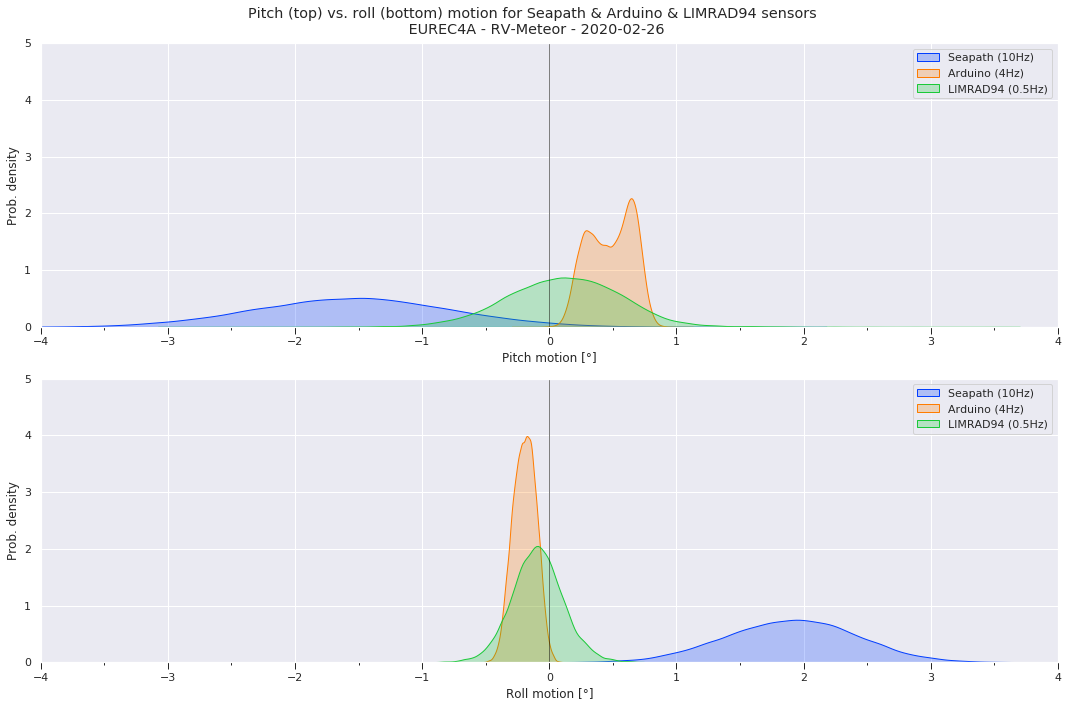

In [14]:
fig, axs = plt.subplots(2, 1, sharex=False, figsize=(15,10))

axs[0].set(xlim=(-4, 4))
axs[0].set(ylim=(0, 5))
axs[1].set(xlim=(-4, 4))
axs[1].set(ylim=(0, 5))

#fig = plt.gcf()
#fig.set_size_inches(15, 7)
sns.set_theme(style='darkgrid', palette='bright')

sns.kdeplot(instruments['seapath_pitch'], ax=axs[0], shade=True, label='Seapath (10Hz)')
sns.kdeplot(instruments['arduino_pitch'], ax=axs[0], shade=True, label='Arduino (4Hz)')
sns.kdeplot(instruments['limrad94_pitch'], ax=axs[0], shade=True, label='LIMRAD94 (0.5Hz)')

axs[0].axvline(x=0, lw=0.5, color='black')

axs[0].tick_params(which="both", bottom=True)
x_lims = axs[0].get_xlim()
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0].set_xticks(np.arange(x_lims[0],x_lims[1], 0.5), minor=True)
axs[0].tick_params(axis='x', which='minor', length=3)
axs[0].tick_params(axis='x', which='major', length=7, width=1)

axs[0].set_ylabel('Prob. density')
axs[0].set_xlabel('Pitch motion [°]')
axs[0].legend()

sns.kdeplot(instruments['seapath_roll'], ax=axs[1], shade=True, label='Seapath (10Hz)')
sns.kdeplot(instruments['arduino_roll'], ax=axs[1], shade=True, label='Arduino (4Hz)')
sns.kdeplot(instruments['limrad94_roll'], ax=axs[1], shade=True, label='LIMRAD94 (0.5Hz)')

#plt.title(f"Seapath vs. Arduino vs. LIMRAD94 probability density for roll motion \n EUREC4A - RV-METEOR - {date:%Y-%m-%d}")
#plt.xlabel("Roll motion [°]")
#plt.ylabel("Prob. density")
#plt.legend()

axs[1].axvline(x=0, lw=0.5, color='black')

axs[1].tick_params(which="both", bottom=True)
x_lims = axs[1].get_xlim()
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1].set_xticks(np.arange(x_lims[0],x_lims[1], 0.5), minor=True)
axs[1].tick_params(axis='x', which='minor', length=3)
axs[1].tick_params(axis='x', which='major', length=7, width=1)

axs[1].set_xlabel('Roll motion [°]')
axs[1].set_ylabel('Prob. density')
axs[1].legend()

plt.suptitle(f'Pitch (top) vs. roll (bottom) motion for Seapath & Arduino & LIMRAD94 sensors \n EUREC4A - RV-Meteor - {date:%Y-%m-%d}')

fig.tight_layout()
plt.subplots_adjust(top=0.93)